# Machine Learning Engineer Nanodegree
## Capstone Project
## Project: Toxic Comment Classification with CNN

Solution Implementation - with sklearn GridSearch

In this step, we did the following:
* train the final model selected
* run the prediction on the unseen test dataset
* plot the roc curves
* plot roc_auc train and validation scores vs tunable
* save results in csv file
* save best model in pkl file

The CNN model has the following parameters:
* regions: [2,3,4]
* number of filters: 32
* spatial dropout rate: 0.4
* dropout rate: 0.2
* activation function: tanh
* epochs: 25
* batch size: 256
* no stop words removing
* not removing IPs, usernames and URL links
* validation dataset: 10%
* optimizer: adadelta(lr=1.0,rho=0.95,epsilon=None,decay=0.0)
* loss function: binary_crossentropy



The GridSearch has the following settings:
* return_train_score=True
* param_grid=param_grid
* cv = ShuffleSplit(n_splits = 5, test_size = 0.1)
* scoring = {'AUC': 'roc_auc'}
* refit='AUC'
* verbose=10

GridSearch tunable parameters is define in param_grid. The following example tune optimizer:
* param_grid={'k': [[2,3,4]], 
            'activation': ['tanh'],
            'filters': [32],
            'Sdroprate':[0.4],
            'droprate': [0.2],
            'optimizer': ['adadelta', 'adagrad','adam','rmsprop'],
            'epochs': [25],
            'batch_size': [256]}

The default parameters are used for Keras tokenizer:
* (num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~ 
', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)

The following input files are located in the same directory as this notebook. 

1. train.csv - the training set, contains comments with their binary labels
2. test.csv - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.
3. test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring; (Note: file added after competition close!)
4. crawl-300d-2M.vec - the pre-trained word vectors

Output files
1. The best model is saved at the location pointed by saved_model variable. 
2. The prediction results are saved as csv file at the location pointed by save_path variable.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
np.random.seed(8)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

import re
import warnings
warnings.filterwarnings('ignore')

# Read in train and test datasets from csv files
train = pd.read_csv('train.csv')
test_cm = pd.read_csv('test.csv')
test_lb = pd.read_csv('test_labels.csv')
# Merge test comments with test labels
test_all = pd.merge(test_cm, test_lb, on='id')
# Remove all test entries with labels equal to -1
test = test_all[test_all['toxic'] != -1]

Using TensorFlow backend.


In [2]:
# Create train and test datasets
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
X_train = train["comment_text"]
y_train = train[label_names].values
X_test = test["comment_text"]
y_test = test[label_names].values

In [3]:
# Define vocabulary size
vocab = 100000
# Define maximum length of a comment
maxlen = 200
# Define embedding size which should equal the embedding size of the pre-trained word vectors
embed_size = 300

In [4]:
# Tokenize the train dataset
t = text.Tokenizer(num_words=vocab)
t.fit_on_texts(list(X_train))

In [5]:
# Convert both train and test datasets into sequences
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [6]:
# Load pre-trained word vectors
EMBEDDING_FILE = 'crawl-300d-2M.vec'
embeddings_index = dict()
f = open(EMBEDDING_FILE)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s pre-trained words' % len(embeddings_index))

Loaded 2000000 pre-trained words


In [7]:
# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab, embed_size))
for word, i in t.word_index.items():
    if i >= vocab: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [8]:
# Define make_model function to create a CNN model
def make_model(k=[7], activation='relu', filters=100, Sdroprate=0.5, droprate=0.0, optimizer='adam'):
    
    # input layer
    inp = Input(shape=(maxlen, ))
    # embedding layer
    x = Embedding(vocab, embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)(inp)
    # spatial dropout layer
    x = SpatialDropout1D(Sdroprate)(x)
    # reshape to connect to 2D layer
    x = Reshape((maxlen, embed_size, 1))(x)
    
    # Convolutional and 1-max pooling layers
    conv = dict()
    maxpool = dict()
    for h in k:
        conv[h] = Conv2D(filters, kernel_size=(h, embed_size), activation=activation)(x)
        maxpool[h] = MaxPool2D(pool_size=(maxlen - h + 1, 1))(conv[h])
        
    if len(k) == 1:
        y = maxpool[h]
    else:
        # concatenate all maxpooling layers
        y = Concatenate(axis=1)([pool for key,pool in maxpool.items()])
    
    # flatten layer
    y = Flatten()(y)
    # dropout layer
    y = Dropout(droprate)(y)

    # output dense layer
    outp = Dense(6, activation="sigmoid")(y)

    # Generate CNN model
    model = Model(inputs=inp, outputs=outp)
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model
# Make the model based on the default parameters
model = make_model()
# Print out the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 300)          30000000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 300)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 200, 300, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 194, 1, 100)       210100    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 100)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
__________

In [9]:
# Define tuning parameters
param_grid={'k': [[2,3,4]], 
            'activation': ['tanh'],
            'filters': [32],
            'Sdroprate':[0.4],
            'droprate': [0.2],
            'optimizer': ['adadelta','adagrad','adam','rmsprop'],
            'epochs': [25],
            'batch_size': [256]}
# Define the cross validation split
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits = 5, test_size = 0.1)
# Define metric for scoring
scoring = {'AUC': 'roc_auc'}

In [10]:
# Wrap Keras model with KerasClassifier so that it can be used in Sklearn GridSearchCV
# Generate a GridSearchCV instance with the parameters to be tuned
# This is a starting model and we try to check which activation function performs better

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
my_classifier = KerasClassifier(make_model, verbose=1)

validator = GridSearchCV(my_classifier, return_train_score=True, param_grid=param_grid,
                        cv = cv, scoring = scoring, refit='AUC', verbose=10)

In [11]:
# Run the Grid Search
grid_result = validator.fit(x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] Sdroprate=0.4, activation=tanh, batch_size=256, droprate=0.2, epochs=25, filters=32, k=[2, 3, 4], optimizer=adadelta 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
143613/143613 [==============================] - 399s 3ms/step - loss: 0.0945 - acc: 0.9722
Epoch 2/25
143613/143613 [==============================] - 396s 3ms/step - loss: 0.0559 - acc: 0.9798
Epoch 3/25
143613/143613 [==============================] - 393s 3ms/step - loss: 0.0522 - acc: 0.9808
Epoch 4/25
143613/143613 [==============================] - 391s 3ms/step - loss: 0.0499 - acc: 0.9814
Epoch 5/25
143613/143613 [==============================] - 391s 3ms/step - loss: 0.0486 - acc: 0.9819
Epoch 6/25
143613/143613 [==============================] - 390s 3ms/step - loss: 0.0473 - acc: 0.9822
Epoch 7/25
143613/143613 [==============================] - 391s 3ms/step - loss: 0.0467 - acc: 0.9824
Epoch 8/25
143613/143613 [==============================] - 390s 3ms/step - loss: 0.0459 - acc: 0.9826
Epoch 9/25
143613/143613 [==============================] - 380s 3ms/step - loss: 0.0453 - acc: 0.9829
Epoch 10/25
143613/143613 [==============================] - 380s 3ms/ste

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 162.4min remaining:    0.0s


Epoch 1/25
143613/143613 [==============================] - 382s 3ms/step - loss: 0.0928 - acc: 0.9726
Epoch 2/25
143613/143613 [==============================] - 382s 3ms/step - loss: 0.0553 - acc: 0.9802
Epoch 3/25
143613/143613 [==============================] - 383s 3ms/step - loss: 0.0516 - acc: 0.9811
Epoch 4/25
143613/143613 [==============================] - 383s 3ms/step - loss: 0.0497 - acc: 0.9816
Epoch 5/25
143613/143613 [==============================] - 381s 3ms/step - loss: 0.0483 - acc: 0.9820
Epoch 6/25
143613/143613 [==============================] - 380s 3ms/step - loss: 0.0472 - acc: 0.9823
Epoch 7/25
143613/143613 [==============================] - 380s 3ms/step - loss: 0.0466 - acc: 0.9825
Epoch 8/25
143613/143613 [==============================] - 380s 3ms/step - loss: 0.0458 - acc: 0.9827
Epoch 9/25
143613/143613 [==============================] - 380s 3ms/step - loss: 0.0454 - acc: 0.9828
Epoch 10/25
143613/143613 [==============================] - 380s 3ms/ste

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 323.0min remaining:    0.0s


Epoch 1/25
143613/143613 [==============================] - 381s 3ms/step - loss: 0.0964 - acc: 0.9720
Epoch 2/25
143613/143613 [==============================] - 380s 3ms/step - loss: 0.0567 - acc: 0.9797
Epoch 3/25
143613/143613 [==============================] - 379s 3ms/step - loss: 0.0523 - acc: 0.9810
Epoch 4/25
143613/143613 [==============================] - 379s 3ms/step - loss: 0.0501 - acc: 0.9813
Epoch 5/25
143613/143613 [==============================] - 380s 3ms/step - loss: 0.0487 - acc: 0.9818
Epoch 6/25
143613/143613 [==============================] - 380s 3ms/step - loss: 0.0477 - acc: 0.9820
Epoch 7/25
143613/143613 [==============================] - 380s 3ms/step - loss: 0.0470 - acc: 0.9823
Epoch 8/25
143613/143613 [==============================] - 380s 3ms/step - loss: 0.0463 - acc: 0.9825
Epoch 9/25
143613/143613 [==============================] - 380s 3ms/step - loss: 0.0454 - acc: 0.9828
Epoch 10/25
143613/143613 [==============================] - 381s 3ms/ste

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 483.8min remaining:    0.0s


Epoch 1/25
143613/143613 [==============================] - 377s 3ms/step - loss: 0.0950 - acc: 0.9721
Epoch 2/25
143613/143613 [==============================] - 374s 3ms/step - loss: 0.0562 - acc: 0.9798
Epoch 3/25
143613/143613 [==============================] - 374s 3ms/step - loss: 0.0519 - acc: 0.9809
Epoch 4/25
143613/143613 [==============================] - 373s 3ms/step - loss: 0.0497 - acc: 0.9816
Epoch 5/25
143613/143613 [==============================] - 374s 3ms/step - loss: 0.0485 - acc: 0.9818
Epoch 6/25
143613/143613 [==============================] - 374s 3ms/step - loss: 0.0478 - acc: 0.9821
Epoch 7/25
143613/143613 [==============================] - 374s 3ms/step - loss: 0.0469 - acc: 0.9823
Epoch 8/25
143613/143613 [==============================] - 373s 3ms/step - loss: 0.0465 - acc: 0.9825
Epoch 9/25
143613/143613 [==============================] - 373s 3ms/step - loss: 0.0456 - acc: 0.9827
Epoch 10/25
143613/143613 [==============================] - 373s 3ms/ste

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 641.4min remaining:    0.0s


Epoch 1/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0943 - acc: 0.9720
Epoch 2/25
143613/143613 [==============================] - 375s 3ms/step - loss: 0.0561 - acc: 0.9800
Epoch 3/25
143613/143613 [==============================] - 375s 3ms/step - loss: 0.0521 - acc: 0.9807
Epoch 4/25
143613/143613 [==============================] - 375s 3ms/step - loss: 0.0498 - acc: 0.9815
Epoch 5/25
143613/143613 [==============================] - 375s 3ms/step - loss: 0.0487 - acc: 0.9818
Epoch 6/25
143613/143613 [==============================] - 374s 3ms/step - loss: 0.0476 - acc: 0.9822
Epoch 7/25
143613/143613 [==============================] - 375s 3ms/step - loss: 0.0467 - acc: 0.9823
Epoch 8/25
143613/143613 [==============================] - 375s 3ms/step - loss: 0.0462 - acc: 0.9824
Epoch 9/25
143613/143613 [==============================] - 375s 3ms/step - loss: 0.0453 - acc: 0.9828
Epoch 10/25
143613/143613 [==============================] - 375s 3ms/ste

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 799.4min remaining:    0.0s


Epoch 1/25
143613/143613 [==============================] - 377s 3ms/step - loss: 0.0700 - acc: 0.9764
Epoch 2/25
143613/143613 [==============================] - 375s 3ms/step - loss: 0.0547 - acc: 0.9803
Epoch 3/25
143613/143613 [==============================] - 375s 3ms/step - loss: 0.0517 - acc: 0.9809
Epoch 4/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0503 - acc: 0.9814
Epoch 5/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0489 - acc: 0.9818
Epoch 6/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0484 - acc: 0.9819
Epoch 7/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0477 - acc: 0.9820
Epoch 8/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0469 - acc: 0.9823
Epoch 9/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0469 - acc: 0.9823
Epoch 10/25
143613/143613 [==============================] - 376s 3ms/ste

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 957.9min remaining:    0.0s


Epoch 1/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0730 - acc: 0.9753
Epoch 2/25
143613/143613 [==============================] - 375s 3ms/step - loss: 0.0552 - acc: 0.9800
Epoch 3/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0524 - acc: 0.9808
Epoch 4/25
143613/143613 [==============================] - 375s 3ms/step - loss: 0.0508 - acc: 0.9811
Epoch 5/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0493 - acc: 0.9816
Epoch 6/25
143613/143613 [==============================] - 375s 3ms/step - loss: 0.0486 - acc: 0.9817
Epoch 7/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0482 - acc: 0.9819
Epoch 8/25
143613/143613 [==============================] - 375s 3ms/step - loss: 0.0471 - acc: 0.9823
Epoch 9/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0466 - acc: 0.9823
Epoch 10/25
143613/143613 [==============================] - 376s 3ms/ste

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 1116.2min remaining:    0.0s


Epoch 1/25
143613/143613 [==============================] - 377s 3ms/step - loss: 0.0693 - acc: 0.9766
Epoch 2/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0539 - acc: 0.9806
Epoch 3/25
143613/143613 [==============================] - 377s 3ms/step - loss: 0.0513 - acc: 0.9811
Epoch 4/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0496 - acc: 0.9816
Epoch 5/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0485 - acc: 0.9819
Epoch 6/25
143613/143613 [==============================] - 377s 3ms/step - loss: 0.0479 - acc: 0.9819
Epoch 7/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0472 - acc: 0.9822
Epoch 8/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0467 - acc: 0.9824
Epoch 9/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0465 - acc: 0.9824
Epoch 10/25
143613/143613 [==============================] - 377s 3ms/ste

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 1275.1min remaining:    0.0s


Epoch 1/25
143613/143613 [==============================] - 379s 3ms/step - loss: 0.0703 - acc: 0.9762
Epoch 2/25
143613/143613 [==============================] - 378s 3ms/step - loss: 0.0542 - acc: 0.9803
Epoch 3/25
143613/143613 [==============================] - 378s 3ms/step - loss: 0.0514 - acc: 0.9811
Epoch 4/25
143613/143613 [==============================] - 378s 3ms/step - loss: 0.0503 - acc: 0.9813
Epoch 5/25
143613/143613 [==============================] - 385s 3ms/step - loss: 0.0492 - acc: 0.9816
Epoch 6/25
143613/143613 [==============================] - 380s 3ms/step - loss: 0.0483 - acc: 0.9819
Epoch 7/25
143613/143613 [==============================] - 379s 3ms/step - loss: 0.0475 - acc: 0.9821
Epoch 8/25
143613/143613 [==============================] - 378s 3ms/step - loss: 0.0470 - acc: 0.9823
Epoch 9/25
143613/143613 [==============================] - 378s 3ms/step - loss: 0.0465 - acc: 0.9824
Epoch 10/25
143613/143613 [==============================] - 379s 3ms/ste

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 1434.9min remaining:    0.0s


Epoch 1/25
143613/143613 [==============================] - 381s 3ms/step - loss: 0.0716 - acc: 0.9761
Epoch 2/25
143613/143613 [==============================] - 380s 3ms/step - loss: 0.0543 - acc: 0.9804
Epoch 3/25
143613/143613 [==============================] - 379s 3ms/step - loss: 0.0519 - acc: 0.9809
Epoch 4/25
143613/143613 [==============================] - 379s 3ms/step - loss: 0.0503 - acc: 0.9813
Epoch 5/25
143613/143613 [==============================] - 379s 3ms/step - loss: 0.0491 - acc: 0.9817
Epoch 6/25
143613/143613 [==============================] - 378s 3ms/step - loss: 0.0483 - acc: 0.9819
Epoch 7/25
143613/143613 [==============================] - 378s 3ms/step - loss: 0.0478 - acc: 0.9821
Epoch 8/25
143613/143613 [==============================] - 378s 3ms/step - loss: 0.0470 - acc: 0.9822
Epoch 9/25
143613/143613 [==============================] - 378s 3ms/step - loss: 0.0467 - acc: 0.9822
Epoch 10/25
143613/143613 [==============================] - 378s 3ms/ste

143613/143613 [==============================] - 376s 3ms/step - loss: 0.0400 - acc: 0.9846
Epoch 23/25
143613/143613 [==============================] - 376s 3ms/step - loss: 0.0401 - acc: 0.9846
Epoch 24/25
143613/143613 [==============================] - 380s 3ms/step - loss: 0.0402 - acc: 0.9843
Epoch 25/25
143613/143613 [==============================] - 97s 672us/step
[CV]  Sdroprate=0.4, activation=tanh, batch_size=256, droprate=0.2, epochs=25, filters=32, k=[2, 3, 4], optimizer=adam, AUC=0.9846298334345853, total=157.6min
[CV] Sdroprate=0.4, activation=tanh, batch_size=256, droprate=0.2, epochs=25, filters=32, k=[2, 3, 4], optimizer=adam 
Epoch 1/25
143613/143613 [==============================] - 381s 3ms/step - loss: 0.0880 - acc: 0.9737
Epoch 2/25
143613/143613 [==============================] - 378s 3ms/step - loss: 0.0526 - acc: 0.9807
Epoch 3/25
143613/143613 [==============================] - 378s 3ms/step - loss: 0.0491 - acc: 0.9815
Epoch 4/25
143613/143613 [===========

143613/143613 [==============================] - 377s 3ms/step - loss: 0.0420 - acc: 0.9838
Epoch 15/25
143613/143613 [==============================] - 378s 3ms/step - loss: 0.0417 - acc: 0.9838
Epoch 16/25
143613/143613 [==============================] - 377s 3ms/step - loss: 0.0416 - acc: 0.9841
Epoch 17/25
143613/143613 [==============================] - 377s 3ms/step - loss: 0.0411 - acc: 0.9841
Epoch 18/25
143613/143613 [==============================] - 377s 3ms/step - loss: 0.0410 - acc: 0.9842
Epoch 19/25
143613/143613 [==============================] - 377s 3ms/step - loss: 0.0409 - acc: 0.9841
Epoch 20/25
143613/143613 [==============================] - 377s 3ms/step - loss: 0.0409 - acc: 0.9842
Epoch 21/25
143613/143613 [==============================] - 378s 3ms/step - loss: 0.0405 - acc: 0.9843
Epoch 22/25
143613/143613 [==============================] - 378s 3ms/step - loss: 0.0404 - acc: 0.9843
Epoch 23/25
143613/143613 [==============================] - 378s 3ms/step -

143613/143613 [==============================] - 377s 3ms/step - loss: 0.0448 - acc: 0.9830
Epoch 7/25
143613/143613 [==============================] - 377s 3ms/step - loss: 0.0443 - acc: 0.9832
Epoch 8/25
143613/143613 [==============================] - 377s 3ms/step - loss: 0.0439 - acc: 0.9834
Epoch 9/25
143613/143613 [==============================] - 377s 3ms/step - loss: 0.0432 - acc: 0.9834
Epoch 10/25
143613/143613 [==============================] - 384s 3ms/step - loss: 0.0432 - acc: 0.9835
Epoch 11/25
143613/143613 [==============================] - 383s 3ms/step - loss: 0.0429 - acc: 0.9835
Epoch 12/25
143613/143613 [==============================] - 382s 3ms/step - loss: 0.0426 - acc: 0.9836
Epoch 13/25
143613/143613 [==============================] - 381s 3ms/step - loss: 0.0420 - acc: 0.9839
Epoch 14/25
143613/143613 [==============================] - 381s 3ms/step - loss: 0.0419 - acc: 0.9840
Epoch 15/25
143613/143613 [==============================] - 382s 3ms/step - lo

[CV]  Sdroprate=0.4, activation=tanh, batch_size=256, droprate=0.2, epochs=25, filters=32, k=[2, 3, 4], optimizer=rmsprop, AUC=0.9864746812106726, total=159.6min


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 3192.4min finished


Epoch 1/25
159571/159571 [==============================] - 426s 3ms/step - loss: 0.0920 - acc: 0.9725
Epoch 2/25
159571/159571 [==============================] - 425s 3ms/step - loss: 0.0553 - acc: 0.9800
Epoch 3/25
159571/159571 [==============================] - 424s 3ms/step - loss: 0.0515 - acc: 0.9810
Epoch 4/25
159571/159571 [==============================] - 424s 3ms/step - loss: 0.0494 - acc: 0.9817
Epoch 5/25
159571/159571 [==============================] - 424s 3ms/step - loss: 0.0480 - acc: 0.9820
Epoch 6/25
159571/159571 [==============================] - 423s 3ms/step - loss: 0.0470 - acc: 0.9823
Epoch 7/25
159571/159571 [==============================] - 423s 3ms/step - loss: 0.0462 - acc: 0.9826
Epoch 8/25
159571/159571 [==============================] - 424s 3ms/step - loss: 0.0456 - acc: 0.9828
Epoch 9/25
159571/159571 [==============================] - 423s 3ms/step - loss: 0.0449 - acc: 0.9829
Epoch 10/25
159571/159571 [==============================] - 424s 3ms/ste

In [12]:
print("Best score: %f with %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_AUC']
stds = grid_result.cv_results_['std_test_AUC']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# Get the best model
best_model = validator.best_estimator_.model

Best score: 0.987841 with {'Sdroprate': 0.4, 'activation': 'tanh', 'batch_size': 256, 'droprate': 0.2, 'epochs': 25, 'filters': 32, 'k': [2, 3, 4], 'optimizer': 'adadelta'}
0.987841 (0.001818) with: {'Sdroprate': 0.4, 'activation': 'tanh', 'batch_size': 256, 'droprate': 0.2, 'epochs': 25, 'filters': 32, 'k': [2, 3, 4], 'optimizer': 'adadelta'}
0.986751 (0.002053) with: {'Sdroprate': 0.4, 'activation': 'tanh', 'batch_size': 256, 'droprate': 0.2, 'epochs': 25, 'filters': 32, 'k': [2, 3, 4], 'optimizer': 'adagrad'}
0.987397 (0.001620) with: {'Sdroprate': 0.4, 'activation': 'tanh', 'batch_size': 256, 'droprate': 0.2, 'epochs': 25, 'filters': 32, 'k': [2, 3, 4], 'optimizer': 'adam'}
0.987294 (0.001485) with: {'Sdroprate': 0.4, 'activation': 'tanh', 'batch_size': 256, 'droprate': 0.2, 'epochs': 25, 'filters': 32, 'k': [2, 3, 4], 'optimizer': 'rmsprop'}


In [13]:
grid_result.cv_results_

{'mean_fit_time': array([9487.615027  , 9433.62753582, 9451.68554902, 9510.2585536 ]),
 'std_fit_time': array([107.21088498,  34.35343451,  10.28414057,  74.88887634]),
 'mean_score_time': array([10.73835597, 10.89285603, 11.03393083, 11.23838224]),
 'std_score_time': array([0.07602766, 0.12107927, 0.11845434, 0.26643272]),
 'param_Sdroprate': masked_array(data=[0.4, 0.4, 0.4, 0.4],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_activation': masked_array(data=['tanh', 'tanh', 'tanh', 'tanh'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_batch_size': masked_array(data=[256, 256, 256, 256],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_droprate': masked_array(data=[0.2, 0.2, 0.2, 0.2],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_epochs': 

In [14]:
# Perform prediction with unseen test dataset with the best model
y_pred = best_model.predict(x_test, batch_size=256)

In [15]:
# Calculate the roc_auc score
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, y_pred)
print("\n roc_auc score for keras model: %.6f \n" % (score))


 roc_auc score for keras model: 0.982857 



In [16]:
# Define function plot_roc to compute ROC curves and AUCs for test
def plot_roc(y_test, y_pred):
    from sklearn.metrics import roc_curve, auc
    from scipy import interp

    # Compute false positive rate (fpr), true positive rate (tpr) and area under the curves (rocauc)
    fpr = dict()
    tpr = dict()
    thr = dict()
    rocauc = dict()
    for i in range(y_test.shape[1]):
        fpr[i], tpr[i], thr[i] = roc_curve(y_test[:, i], y_pred[:, i])
        rocauc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thr["micro"] = roc_curve(y_test.ravel(), y_pred.ravel())
    rocauc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute Macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_test.shape[1])]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(y_test.shape[1]):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= y_test.shape[1]

    # Then interpolate all ROC curves at this points
    mean_thr = np.zeros_like(all_fpr)
    for i in range(y_test.shape[1]):
        mean_thr += interp(all_fpr, fpr[i], thr[i])

    # Finally average it and compute AUC
    mean_thr /= y_test.shape[1]

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    thr["macro"] = mean_thr
    rocauc["macro"] = auc(fpr["macro"], tpr["macro"])

    # to increase tpr, you also increase fpr. It is a trade off between the two.
    # Business requirement determine which one is more important
    # We can calculate the threshold to garantee a minimum tpr or a maximum fpr
    # We see here that to increase tpr, we need to lower threshold
    # to decrease fpr, we need to increase threshold

    tpr_cut = 0.90
    fpr_cut = 0.10
    label = 'toxic'
    idx = label_names.index(label)
    
    # index of the first threshold for which the sensitivity > tpr_cut
    idx1 = np.min(np.where(tpr["micro"] > tpr_cut)) 
    # index of the first threshold for which the fall out < fpr_cut
    idx2 = np.max(np.where(fpr["micro"] < fpr_cut)) 
    # index of the first threshold for which the sensitivity > tpr_cut
    idx3 = np.min(np.where(tpr["macro"] > tpr_cut)) 
    # index of the first threshold for which the fall out < fpr_cut
    idx4 = np.max(np.where(fpr["macro"] < fpr_cut)) 
    # index of the first threshold for which the sensitivity > tpr_cut
    idx5 = np.min(np.where(tpr[idx] > tpr_cut)) 
    # index of the first threshold for which the fall out < fpr_cut
    idx6 = np.max(np.where(fpr[idx] < fpr_cut)) 

    '''
    print("Micro Average tpr > %.2f: %.4f" % (tpr_cut,thr["micro"][idx1]))
    print("Micro Average fpr < %.2f: %.4f" % (fpr_cut,thr["micro"][idx2]))
    print("Macro Average tpr > %.2f: %.4f" % (tpr_cut,thr["macro"][idx3]))
    print("Macro Average fpr < %.2f: %.4f" % (fpr_cut,thr["macro"][idx4]))
    '''
    print('threshold for label "{}" at tpr > {:.2f} is {:.4f}'.format(label,tpr_cut,thr[idx][idx5]))
    print('threshold for label "{}" at fpr < {:.2f} is {:.4f}'.format(label,fpr_cut,thr[idx][idx6]))

    # Plot all ROC curves
    import matplotlib.pyplot as plt
    %matplotlib inline
    from itertools import cycle

    plt.figure(figsize=(10,8))
    lw = 2

    plt.figure(figsize=(10,8))
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(rocauc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(rocauc["macro"]),
         color='navy', linestyle=':', linewidth=4)
    '''
    plt.plot([0,fpr["micro"][idx1]], [tpr["micro"][idx1],tpr["micro"][idx1]], 'k--', color='blue')
    plt.plot([fpr["micro"][idx1],fpr["micro"][idx1]], [0,tpr["micro"][idx1]], 'k--', color='blue')

    plt.plot([0,fpr["micro"][idx2]], [tpr["micro"][idx2],tpr["micro"][idx2]], 'k--', color='red')
    plt.plot([fpr["micro"][idx2],fpr["micro"][idx2]], [0,tpr["micro"][idx2]], 'k--', color='red')

    plt.plot([0,fpr["macro"][idx3]], [tpr["macro"][idx3],tpr["macro"][idx3]], 'k--', color='blue')
    plt.plot([fpr["macro"][idx3],fpr["macro"][idx3]], [0,tpr["macro"][idx3]], 'k--', color='blue')

    plt.plot([0,fpr["macro"][idx4]], [tpr["macro"][idx4],tpr["macro"][idx4]], 'k--', color='red')
    plt.plot([fpr["macro"][idx4],fpr["macro"][idx4]], [0,tpr["macro"][idx4]], 'k--', color='red')
    '''
    plt.plot([0,fpr[idx][idx5]], [tpr[idx][idx5],tpr[idx][idx5]], 'k--', color='blue')
    plt.plot([fpr[idx][idx5],fpr[idx][idx5]], [0,tpr[idx][idx5]], 'k--', color='blue')

    plt.plot([0,fpr[idx][idx6]], [tpr[idx][idx6],tpr[idx][idx6]], 'k--', color='red')
    plt.plot([fpr[idx][idx6],fpr[idx][idx6]], [0,tpr[idx][idx6]], 'k--', color='red')

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(y_test.shape[1]), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.4f})'
             ''.format(label_names[i], rocauc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves and Areas under the Curves')
    plt.legend(loc="lower right")
    plt.show()
    return label, idx, thr, idx5, idx6

threshold for label "toxic" at tpr > 0.90 is 0.4314
threshold for label "toxic" at fpr < 0.10 is 0.3185


<Figure size 720x576 with 0 Axes>

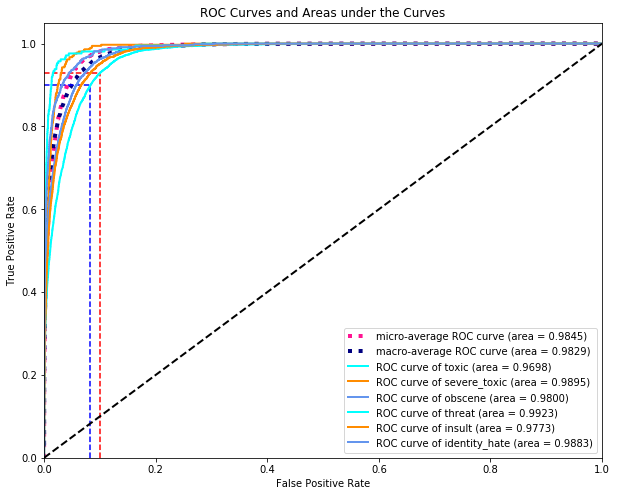

In [17]:
# Plot the roc curves and auc scores
# Also print out thresholds for label toxic
label, idx, thr, idx5, idx6 = plot_roc(y_test, y_pred)

In [18]:
# Generate a summary report for the best model architecture
best_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 200, 300)     30000000    input_22[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_22 (SpatialDr (None, 200, 300)     0           embedding_22[0][0]               
__________________________________________________________________________________________________
reshape_22 (Reshape)            (None, 200, 300, 1)  0           spatial_dropout1d_22[0][0]       
__________________________________________________________________________________________________
conv2d_62 

best params: <keras.wrappers.scikit_learn.KerasClassifier object at 0x1a966b6cc0>
best params: {'Sdroprate': 0.4, 'activation': 'tanh', 'batch_size': 256, 'droprate': 0.2, 'epochs': 25, 'filters': 32, 'k': [2, 3, 4], 'optimizer': 'adadelta'}
best score: 0.9878405805016359


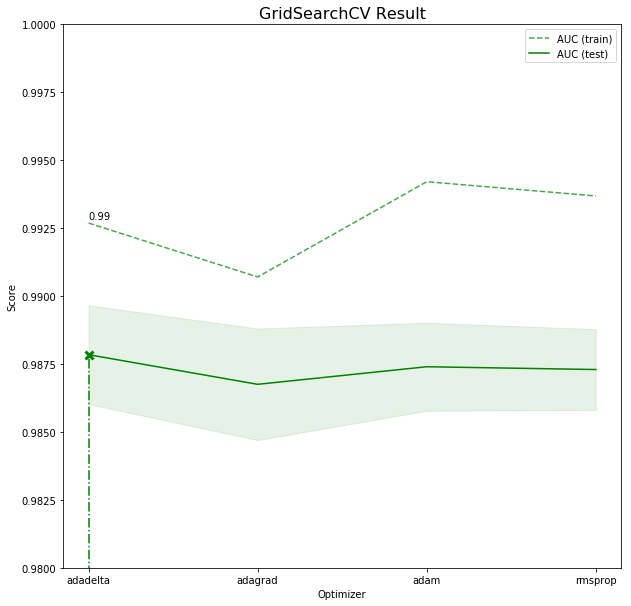

In [20]:
# Plot result of the Grid Search
%matplotlib inline
import matplotlib.pyplot as plt
results = grid_result.cv_results_

print('='*20)
print("best params: " + str(grid_result.best_estimator_))
print("best params: " + str(grid_result.best_params_))
print('best score:', grid_result.best_score_)
print('='*20)

plt.figure(figsize=(10, 10))
plt.title("GridSearchCV Result",fontsize=16)

plt.xlabel("Optimizer")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
#ax.set_xlim(0, max(param_grid['Sdroprate']))
ax.set_ylim(0.98, 1.00)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_optimizer'].data, dtype=object)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]   
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

In [30]:
# Save the prediction on test dataset
save_path = 'finalModelResult.csv'
pred_save = test.copy()
pred_save[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
pred_save.to_csv(save_path, index=False)
pred_test = pd.read_csv(save_path)
pred_test = pred_test[label_names]
score = roc_auc_score(y_test, pred_test)
print("\n roc_auc score: %.6f \n" % (score))


 roc_auc score: 0.982857 



In [31]:
# Dump the model into a file
import pickle
saved_model = 'saved_models/finalModel.pkl'
pickle.dump(best_model, open(saved_model, 'wb'))

In [32]:
# Load the saved model
loaded_model = pickle.load(open(saved_model, 'rb'))
# Perform prediction with unseen test dataset with the loaded model
y_pred_loaded = loaded_model.predict(x_test, batch_size=256)
# Calculate the roc_auc score with unseen test dataset
score = roc_auc_score(y_test, y_pred_loaded)
print("\n roc_auc score for keras model: %.6f \n" % (score))


 roc_auc score for keras model: 0.982857 

